# Left/Right stereotypy in Kenyon cells

In [1]:

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from giskard.plot import histplot, matrixplot
from graspologic.match import GraphMatch
from graspologic.plot import heatmap
from graspologic.utils import binarize
from pkg.data import load_maggot_graph, load_unmatched
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from tqdm import tqdm

DISPLAY_FIGS = True

FILENAME = "kc_stereotypy"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


t0 = time.time()
set_theme()

left_adj, left_nodes = load_unmatched("left")
right_adj, right_nodes = load_unmatched("right")

mg = load_maggot_graph()

left_mg = mg.node_subgraph(mg[mg.nodes["left"]].nodes.index)
right_mg = mg.node_subgraph(mg[mg.nodes["right"]].nodes.index)


nodes = left_mg.nodes
upns_left = nodes[nodes["merge_class"] == "uPN"].index
kcs_left = nodes[(nodes["class1"] == "KC") & (nodes["merge_class"] != "KC-1claw")].index

nodes = right_mg.nodes
upns_right = nodes[nodes["merge_class"] == "uPN"].index
kcs_right = nodes[
    (nodes["class1"] == "KC") & (nodes["merge_class"] != "KC-1claw")
].index

In [2]:

n_upns = len(upns_left)


def remove_unconnected_kcs(adj, index, n_upns):
    n_inputs = adj.sum(axis=0)
    keep_mask = ~((n_inputs == 0) & (np.arange(len(n_inputs)) >= n_upns))
    adj = adj[keep_mask][:, keep_mask]
    index = index[keep_mask]
    return adj, index


left_index = np.concatenate((upns_left, kcs_left))
left_mg.nodes = left_mg.nodes.reindex(left_index)
left_subgraph_mg = left_mg.node_subgraph(upns_left, kcs_left)
left_adj = binarize(left_subgraph_mg.sum.adj)

left_adj, left_index = remove_unconnected_kcs(left_adj, left_index, n_upns)
left_labels = np.array(n_upns * ["uPN"] + (len(left_adj) - n_upns) * ["KC"])

right_index = np.concatenate((upns_right, kcs_right))
right_mg.nodes = right_mg.nodes.reindex(right_index)
right_subgraph_mg = right_mg.node_subgraph(upns_right, kcs_right)
right_adj = binarize(right_subgraph_mg.sum.adj)

right_adj, right_index = remove_unconnected_kcs(right_adj, right_index, n_upns)
right_labels = np.array(n_upns * ["uPN"] + (len(right_adj) - n_upns) * ["KC"])

<AxesSubplot:title={'center':'Right hemisphere'}>

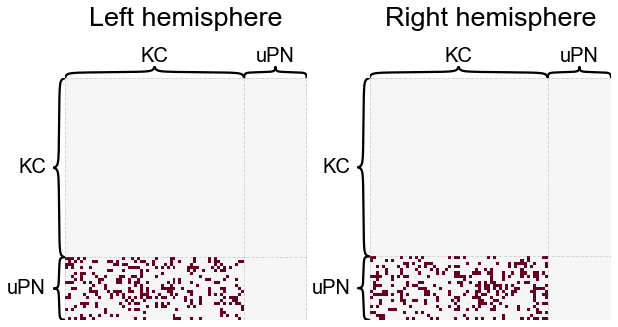

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
heatmap(
    left_adj,
    cbar=False,
    inner_hier_labels=left_labels,
    title="Left hemisphere",
    hier_label_fontsize=20,
    font_scale=1.5,
    ax=axs[0],
)
heatmap(
    right_adj,
    cbar=False,
    inner_hier_labels=right_labels,
    title="Right hemisphere",
    hier_label_fontsize=20,
    font_scale=1.5,
    ax=axs[1],
)

In [4]:
print("Number of uPNs (L vs. R):")
print((left_labels == "uPN").sum())
print("vs")
print((right_labels == "uPN").sum())
print()
print("Number of KCss (L vs. R):")
print((left_labels == "KC").sum())
print("vs")
print((right_labels == "KC").sum())

Number of uPNs (L vs. R):
21
vs
21

Number of KCss (L vs. R):
60
vs
59


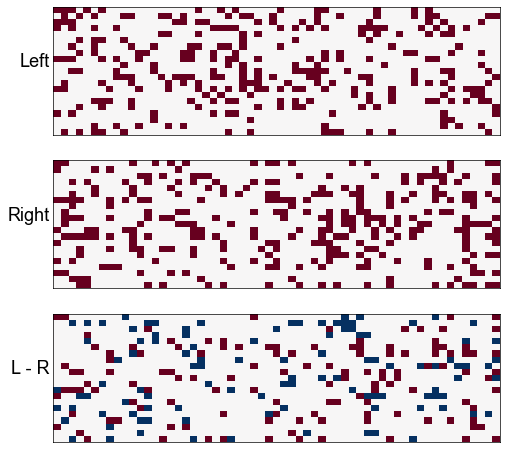

In [5]:


A = right_adj
B = left_adj

n_upns = len(upns_left)

gm = GraphMatch(n_init=25)

gm.fit(A, B, seeds_A=np.arange(n_upns), seeds_B=np.arange(n_upns))

perm_inds = gm.perm_inds_[: len(A)]

B_perm = B[perm_inds][:, perm_inds]

diff = A - B_perm
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

matrixplot(B[:n_upns, n_upns:], cbar=False, ax=axs[0])
matrixplot(A[:n_upns, n_upns:], cbar=False, ax=axs[1])
matrixplot(diff[:n_upns, n_upns:], cbar=False, ax=axs[2])

# axs[0].set_title("KCs (graph matched)")
axs[0].set_ylabel("Left", rotation=0, ha="right")
axs[1].set_ylabel("Right", rotation=0, ha="right")
axs[2].set_ylabel("L - R", rotation=0, ha="right")

fig.set_facecolor("w")

In [6]:


def compute_density(adjacency, loops=False):
    if not loops:
        triu_inds = np.triu_indices_from(adjacency, k=1)
        tril_inds = np.tril_indices_from(adjacency, k=-1)
        n_edges = np.count_nonzero(adjacency[triu_inds]) + np.count_nonzero(
            adjacency[tril_inds]
        )
    else:
        n_edges = np.count_nonzero(adjacency)
    n_nodes = adjacency.shape[0]
    n_possible = n_nodes**2
    if not loops:
        n_possible -= n_nodes
    return n_edges / n_possible


def compute_alignment_strength(A, B, perm=None):
    n = A.shape[0]
    if perm is not None:
        B_perm = B[perm][:, perm]
    else:
        B_perm = B
    n_disagreements = np.count_nonzero(A - B_perm)  # TODO this assumes loopless
    p_disagreements = n_disagreements / (n**2 - n)
    densityA = compute_density(A)
    densityB = compute_density(B)
    denominator = densityA * (1 - densityB) + densityB * (1 - densityA)
    alignment_strength = 1 - p_disagreements / denominator
    return alignment_strength


def obj_func(A, B, perm):
    PBPT = B[perm[: len(A)]][:, perm[: len(A)]]
    return np.linalg.norm(A - PBPT, ord="fro") ** 2, PBPT

In [7]:


n_init = 25

rows = []

gm = GraphMatch(n_init=n_init)
gm.fit(A, B, seeds_A=np.arange(n_upns), seeds_B=np.arange(n_upns))
perm_inds = gm.perm_inds_
score, B_perm = obj_func(A, B, perm_inds)
alignment = compute_alignment_strength(A, B_perm)

rows.append({"data": "Observed", "score": score, "alignment": alignment})


def get_subgraph(A):
    return A[:n_upns, n_upns:]


def make_subgraph(A):
    A = A.copy()
    # all KC to upn
    A[n_upns:] = 0
    # all PN to PN
    A[:n_upns, :n_upns] = 0
    return A


def er_subgraph(size, p, rng=None):
    subgraph = rng.binomial(1, p, size=size)
    n = size[0] + size[1]
    A = np.zeros((n, n))
    A[:n_upns, n_upns:] = subgraph
    return A


A_sub_adj = get_subgraph(A)
B_sub_adj = get_subgraph(B)

p_A = np.count_nonzero(A_sub_adj) / A_sub_adj.size
p_B = np.count_nonzero(B_sub_adj) / B_sub_adj.size
n = A_sub_adj.shape[1]

rng = np.random.default_rng(8888)
n_sims = 500

for sim in tqdm(range(n_sims)):
    A_sim = er_subgraph(A_sub_adj.shape, p_A, rng)
    B_sim = er_subgraph(A_sub_adj.shape, p_B, rng)

    gm = GraphMatch(n_init=n_init)
    gm.fit(A_sim, B_sim, seeds_A=np.arange(n_upns), seeds_B=np.arange(n_upns))
    perm_inds = gm.perm_inds_
    score, B_sim_perm = obj_func(A_sim, B_sim, perm_inds)
    alignment = compute_alignment_strength(A_sim, B_sim_perm)

    rows.append({"data": "ER", "score": score, "alignment": alignment})

results = pd.DataFrame(rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 29.77it/s]


In [8]:
observed_alignment = results[results["data"] == "Observed"].iloc[0]["alignment"]
prop_less_than = (
    results[results["data"] == "ER"]["alignment"].values < observed_alignment
).mean()

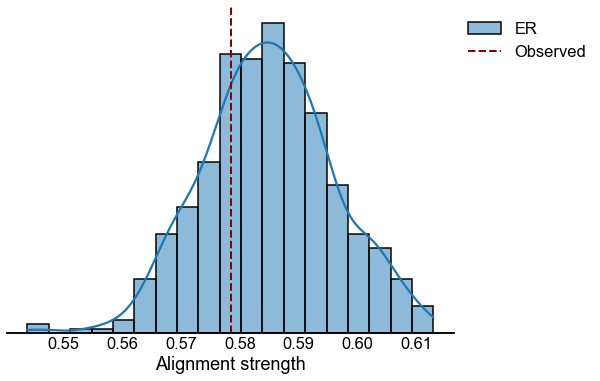

In [9]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
histplot(data=results, x="alignment", hue="data", kde=True, ax=ax)
ax.set(ylabel="", yticks=[], xlabel="Alignment strength")
ax.spines["left"].set_visible(False)

gluefig("alignment_dist", fig)

In [10]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:25.703339
Completed at 2022-04-29 09:50:03.397751
